In [1]:
import cv2
from darkflow.net.build import TFNet
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pickle

# %config InlineBackend.figure_format = 'svg'
%matplotlib inline


## YOLO definition

In [2]:
# define the model options and run
options = {
    'model': './YOLO/cfg/yolo-voc.cfg',
    'load': './YOLO/weights/yolo-voc.weights',
    'threshold': 0.40,
    'gpu': 0.7,
}

yolonet = TFNet(options)

C:\Users\morit\Anaconda3\envs\carnd-term1_gpu\lib\site-packages\darkflow\dark\darknet.py:54: UserWarning: ./cfg/yolo-voc.cfg not found, use ./YOLO/cfg/yolo-voc.cfg instead
  cfg_path, FLAGS.model))


Parsing ./YOLO/cfg/yolo-voc.cfg
Loading ./YOLO/weights/yolo-voc.weights ...
Successfully identified 202704260 bytes
Finished in 0.03150367736816406s
Model has a VOC model name, loading VOC labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 128)
 Load  |  Yep

## CLASS definition

In [27]:

class car_boxes():
    def __init__(self, history_depth=9, threshold=3, rtol = 0.15, max_no_boxes = 5):
        self.history_depth = history_depth
        self.threshold = threshold
        self.rtol = rtol
        self.max_no_boxes = max_no_boxes
        self.history = np.array([])
        self.current_box = np.zeros((2,2))
        self.possible_car_box = np.empty((history_depth, 2, 2))
        self.moving_avg_result = []

    def add_frame_result(self, yolo_result):

        self.current_frame = np.empty((self.max_no_boxes, 2, 2))
        self.current_frame[:] = np.nan

        for box in yolo_result:
            label = box['label']

            if label =='car':
                tl = (box['topleft']['x'], box['topleft']['y'])
                br = (box['bottomright']['x'], box['bottomright']['y'])                
                self.current_box[0] = tl
                self.current_box[1] = br
                
                car_no = np.where(np.isnan(self.current_frame))[0][0]
                self.current_frame[car_no] = np.copy([self.current_box])

        self.__update_history() 
        self.moving_avg_result = np.array([])
        self.__valid_frame_result()
        
        return self.moving_avg_result.astype('uint16')
        

    def __update_history(self):
        # update history
        if self.history.size ==0 :
            self.history = np.copy([self.current_frame])         
        else:
            self.history = np.append(self.history, [self.current_frame], axis= 0)
            
        if self.history.shape[0] > self.history_depth:
            self.history = self.history[1:,:,:]

    def __valid_frame_result(self):
        not_NAN_c_boxes = sum(~np.isnan(self.current_frame[0:self.max_no_boxes, 0, 0]))
        for c, c_box in enumerate(self.current_frame[0:not_NAN_c_boxes]):
            validated = 0
            self.possible_car_box[:] = np.nan
            
            not_NAN_frames = np.where(~np.isnan(self.history[:-1, 0, 0, 0]))

            for f, frame in enumerate(self.history[not_NAN_frames]):

                not_NAN_h_boxes = np.where(~np.isnan(frame[0:self.max_no_boxes, 0, 0]))
                for h, h_box in enumerate(frame[not_NAN_h_boxes]):

                    if np.allclose(h_box, c_box, rtol = self.rtol):
                        self.possible_car_box[validated] = h_box

                        validated += 1
                        
            if validated >= self.threshold:
                self.possible_car_box = np.append(self.possible_car_box,[c_box], axis=0)
                temp_result = np.round(np.nanmean(self.possible_car_box, axis=0))
                                       
                if self.moving_avg_result.size ==0 :
                    self.moving_avg_result = np.array([temp_result])
                else:
                    self.moving_avg_result = np.append(self.moving_avg_result, [np.round(np.nanmean(self.possible_car_box, axis=0))], axis=0)


## Detection pipeline

In [58]:
car_boxes_avg = car_boxes(15,3)

def process_frame_yolo(img, show_only_cropped = 0, cut_top = 250, cut_buttom = 680, cut_left = 600, cut_right = 1280, debug =0):

    if debug:
        img2 = img.copy()
    frame = img.copy()
    frame = frame[cut_top:cut_buttom, cut_left:cut_right]

    # use YOLO to predict the frame
    result = yolonet.return_predict(frame)

    if show_only_cropped:
        img = frame
        cut_top = 0
        cut_buttom = 0
        cut_left = 0
        cut_right = 0

    moving_avg_result = car_boxes_avg.add_frame_result(result)
    tcolor = (255,50,50)
    
    for b, box in enumerate(moving_avg_result):

        tl = (cut_left + box[0][0], cut_top + box[0][1])
        br = (cut_left + box[1][0], cut_top + box[1][1])
        # add the box 
        img = cv2.rectangle(img, (tl), (br), tcolor, 5)
        img = cv2.putText(img, 'car {}'.format(b+1), (tl[0], tl[1]-10), cv2.FONT_HERSHEY_COMPLEX, 1, tcolor, 5)   
        
    
    text = '{}'.format(moving_avg_result.shape[0]) + ' cars detected'
    cv2.putText(img, text, (40,280), font, 1.5, tcolor, 2, cv2.LINE_AA)
    

    if debug: 
        
        for box in result:
            label = box['label']

            if label =='car':
                tl = (cut_left + box['topleft']['x'], cut_top + box['topleft']['y'])
                br = (cut_left + box['bottomright']['x'], cut_top + box['bottomright']['y'])
                confidence = box['confidence']
                label = box['label'] + ' ' + str(round(confidence,2))

#                 add the box and label and display it
                img2 = cv2.rectangle(img2, tl, br, (215, 7, 75), 5)
                img2 = cv2.putText(img2, label, (tl[0], tl[1]-10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)   
        
        img = np.hstack((img2,img))
    return img


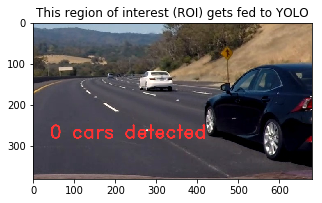

In [59]:
car_boxes_avg = car_boxes(history_depth=4, threshold=3, rtol =0.15)

# read the color image
img = mpimg.imread('./video_images/img_716.jpg')

# crop to get a square image
cut_top = 300
cut_buttom = 680
cut_left = 600
cut_right = 1280

img_processed = process_frame_yolo(img,
                                   show_only_cropped = 1,
                                   cut_top = cut_top,
                                   cut_buttom = cut_buttom,
                                   cut_left = cut_left,
                                   cut_right = cut_right)

plt.figure(figsize=(5,5))
plt.imshow(img_processed)
plt.title('This region of interest (ROI) gets fed to YOLO')
plt.show()


## Example YOLO pipeline

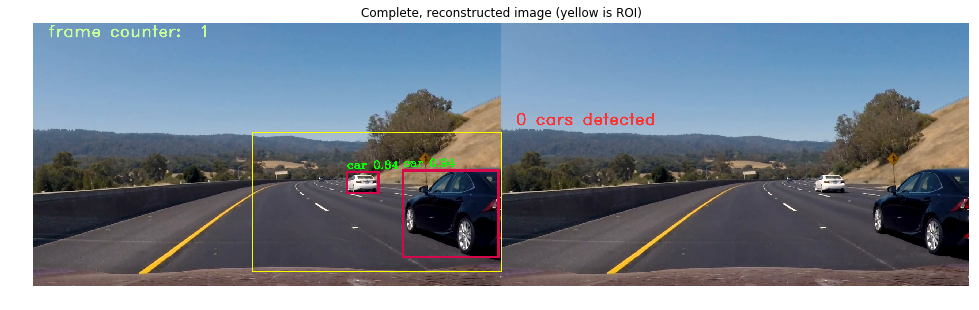

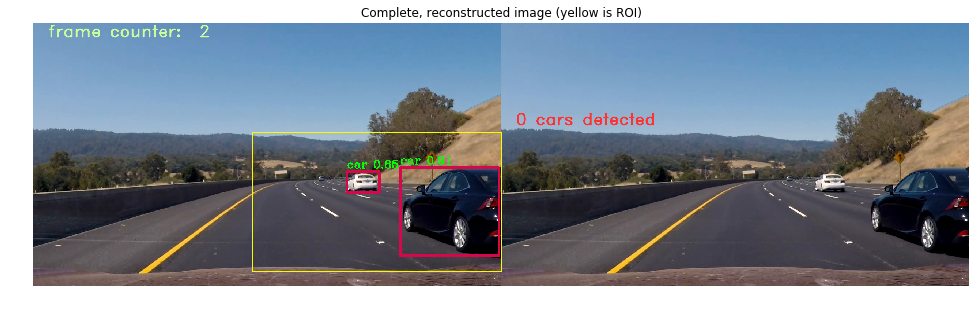

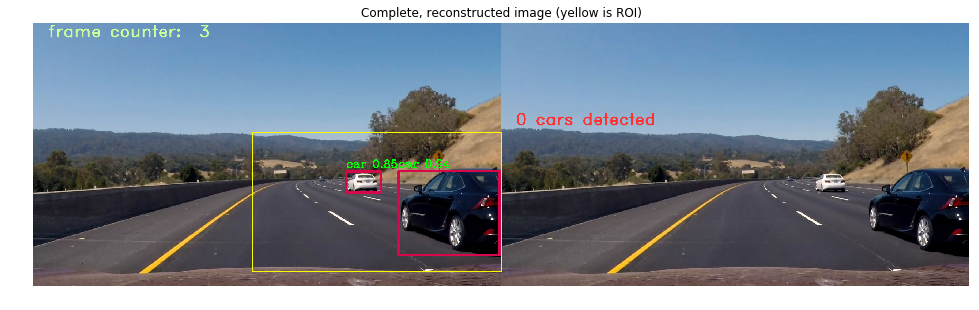

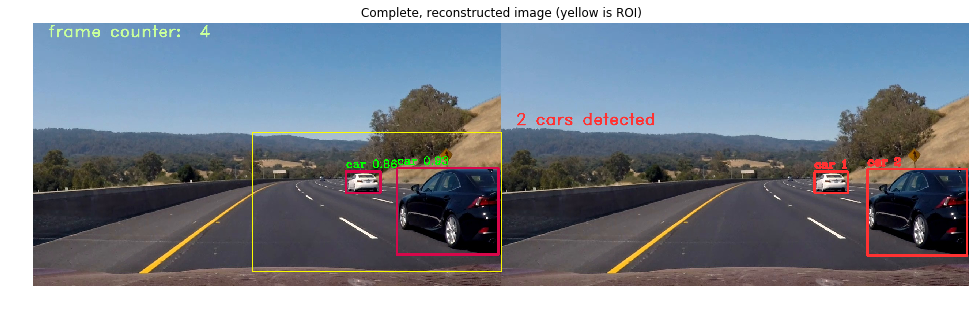

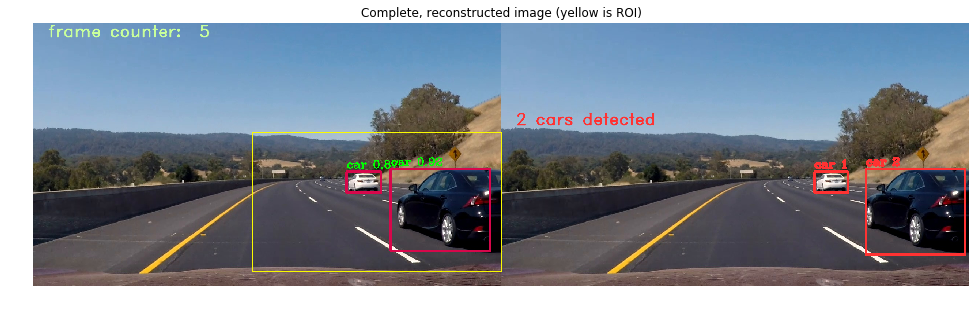

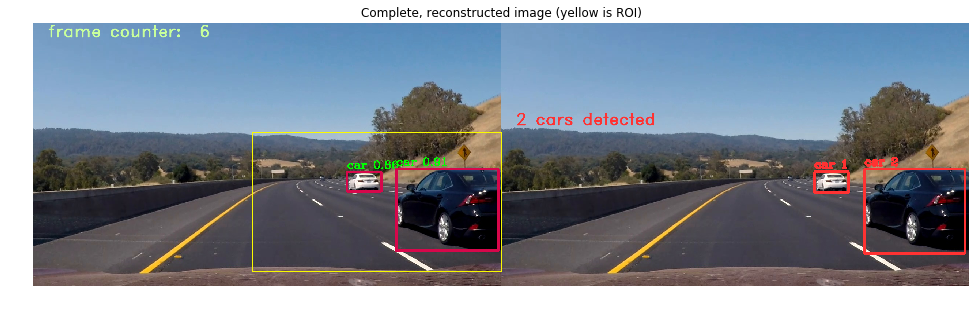

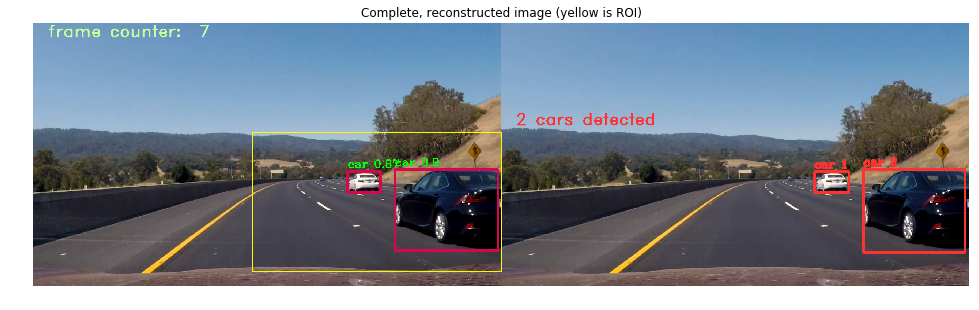

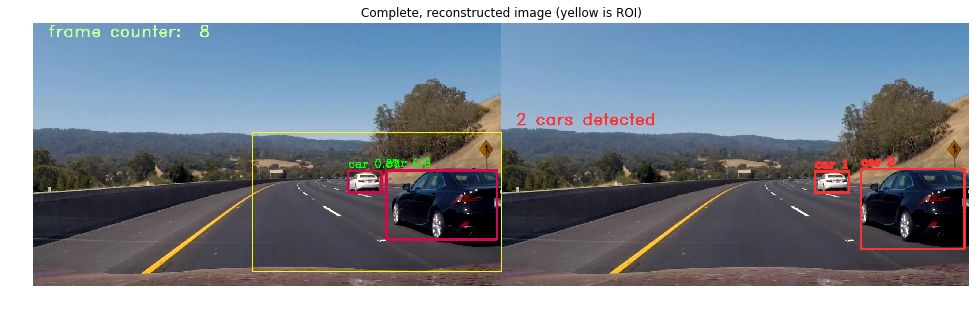

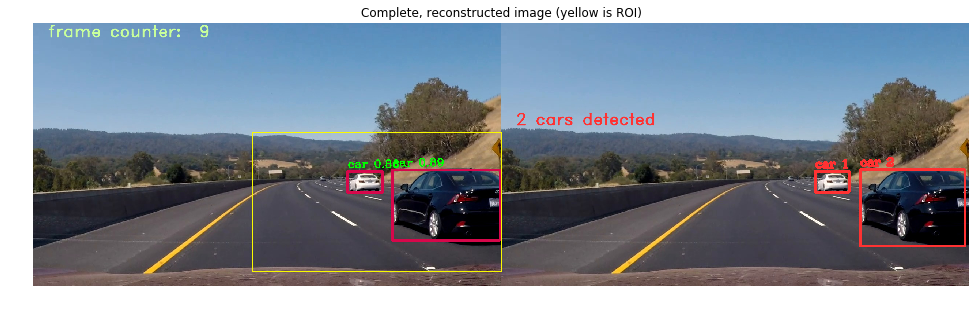

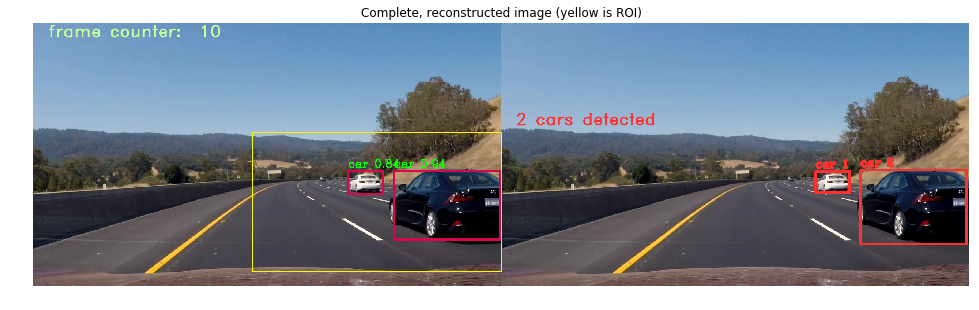

In [60]:

car_boxes_avg = car_boxes(history_depth=5, threshold=3)

images = glob.glob('./video_images2/*.jpg')

for i, img_name in enumerate(images[0:10]):
    img = mpimg.imread(img_name)
    img_processed = process_frame_yolo(img,
                                        cut_left = cut_left,
                                        cut_top = cut_top,
                                        cut_right = cut_right,
                                        cut_buttom = cut_buttom,
                                       show_only_cropped = 0,
                                       debug =1)

    
    img_processed = cv2.rectangle(img_processed, (cut_left, cut_top), (cut_right, cut_buttom), (250, 250, 0), 2)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text_color = (200,255,155)
    text = 'frame counter:  ' + '{}'.format(i+1)
    cv2.putText(img_processed, text, (40,40), font, 1.5, text_color, 2, cv2.LINE_AA)
    
    plt.figure(figsize=(13,5))
    plt.imshow(img_processed)
    plt.axis('off')
    plt.subplots_adjust(top=0.95,bottom=0.05,left=0.0,right=1.0,hspace=0.05,wspace=0.15)
    plt.title('Complete, reconstructed image (yellow is ROI)')
    plt.savefig('./output_images/yolo' + str(i+1) + '.png')
    plt.show()
    

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car_boxes_avg = car_boxes(history_depth=5, threshold=3)

video_output = 'project_video_output_yolo.mp4'
video_input = VideoFileClip('project_video_lane.mp4')#.subclip(20,25)                          
processed_video = video_input.fl_image(process_frame_yolo)
%time processed_video.write_videofile(video_output, audio=False)

############################

car_boxes_avg = car_boxes(history_depth=5, threshold=3)

video_output = 'challenge_video_output_yolo.mp4'
video_input = VideoFileClip('challenge_video_lane.mp4')#.subclip(20,25)                          
processed_video = video_input.fl_image(process_frame_yolo)
%time processed_video.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_output_yolo.mp4
[MoviePy] Writing video project_video_output_yolo.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:55<00:00, 12.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_yolo.mp4 

Wall time: 1min 57s
[MoviePy] >>>> Building video challenge_video_output_yolo.mp4
[MoviePy] Writing video challenge_video_output_yolo.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:37<00:00, 12.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output_yolo.mp4 

Wall time: 39.6 s
